In [1]:
import torch
import torchvision
import numpy as np
import random

In [2]:
torch.cuda.is_available()
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

# Dataset

In [3]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="./data", train=True, download=True, transform=None):
      super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
      image, label = self.data[index], self.targets[index]

      if self.transform is not None:
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, label

In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [5]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mu_cifar = (0.49139968, 0.48215827, 0.44653124)
sigma_cifar = (0.24703233, 0.24348505, 0.26158768)

def augmentation(data, mu=mu_cifar, sigma=sigma_cifar):
    if data == 'Train':
        transform = A.Compose([A.HorizontalFlip(),
                           A.Normalize(mean=mu, std=sigma),
                           ToTensorV2()])
    elif data == 'Test':
        transform = A.Compose([A.Normalize(mean=mu, std=sigma),
                           ToTensorV2()])
    else:
        transform = A.Compose([ToTensorV2()])

    return transform

In [6]:
train_set = Cifar10SearchDataset(train=True, download=True, transform=augmentation('Train'))
test_set = Cifar10SearchDataset(train=False, download=True, transform=augmentation('Test'))
visualize_set = Cifar10SearchDataset(train=False, download=True, transform=augmentation('Visualize'))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(train_set), len(test_set), len(visualize_set)

(50000, 10000, 10000)

In [8]:
import matplotlib.pyplot as plt

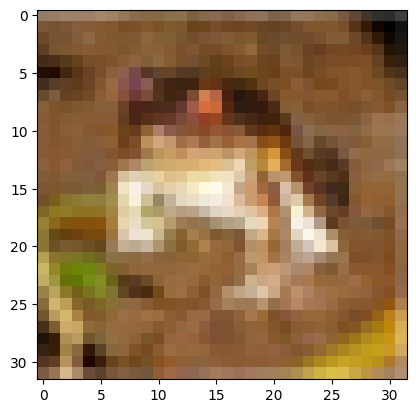

In [9]:
for t in train_set:
    plt.imshow(t[0].permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar)
    plt.show()
    break

In [10]:
def num_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def categorical_to_num(y):
  """ Decodes a 1-hot encoding """
  return np.argmax(y)

In [11]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes_dict = {c:idx for idx, c in enumerate(classes)}

In [12]:

# Dataset is there to be able to interact with DataLoader
from torch.utils.data import Dataset

class cifar10_data(Dataset):
  '''
  cifar10_data class to create an iteratable on our custom cifar10 dataset:
  where data = (image and image label as one-hot-encoding) and labels = (image)
  '''

  def __init__(self, d):
    self.cifar = d                                                              # Initialize with cifar data object

  def __getitem__(self, index):

    image, label = self.cifar[index]
    number_encoding = num_to_categorical(label, 10)                             # 1-hot encoding of number
    number_encoding = torch.tensor(number_encoding)

    return image, number_encoding, image                                        # (input), (output) to network

  def __len__(self):                                                            # Return the length of the dataset
    return len(self.cifar)

In [13]:
train_set_custom = cifar10_data(train_set)
test_set_custom = cifar10_data(test_set)
visualize_set_custom = cifar10_data(visualize_set)

In [14]:
use_cuda = torch.cuda.is_available()                                            # use gpu if available

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 256                                                                  # set size of batch

train_loader = torch.utils.data.DataLoader(                                     # For iterating through our dataset in batches
    train_set_custom,
    batch_size = batch_size,
    shuffle=True,                                                               # Shuffle the data points randomly
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_set_custom,
    batch_size = batch_size,
    shuffle=False,
    **kwargs
)

visualize_loader = torch.utils.data.DataLoader(
    visualize_set_custom,
    batch_size = batch_size,
    shuffle=False,
    **kwargs
)

# Network
Reference: https://github.com/julianstastny/VAE-ResNet18-PyTorch/blob/master/model.py

In [15]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import matplotlib.pyplot as plt
import torch.optim as optim


In [16]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class ResizeConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, scale_factor, mode='nearest'):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x

class BasicBlockEnc(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = in_planes*stride

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if stride == 1:
            self.shortcut = nn.Sequential()
        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlockDec(nn.Module):

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes/stride)

        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride)
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class ResNet18Enc(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 2
        self.z_dim = z_dim
        self.conv1 = nn.Conv2d(nc, 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(2)
        self.layer1 = self._make_layer(BasicBlockEnc, 2, num_Blocks[0], stride=1)
        self.layer2 = self._make_layer(BasicBlockEnc, 4, num_Blocks[1], stride=2)
        self.layer3 = self._make_layer(BasicBlockEnc, 8, num_Blocks[2], stride=2)
        self.layer4 = self._make_layer(BasicBlockEnc, 16, num_Blocks[3], stride=2)
        self.linear = nn.Linear(16, 2 * z_dim)
        self.linear_num = nn.Linear(16+10, 16)
        self.kl = 0

    def _make_layer(self, BasicBlockEnc, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in strides:
            layers += [BasicBlockEnc(self.in_planes, stride)]
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x, num):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        y = torch.cat((x, num), dim=-1)
        y = self.linear_num(y)
        x = self.linear(y)
        mu = x[:, :self.z_dim]
        logvar = x[:, self.z_dim:]
        std = torch.exp(logvar / 2)
        self.kl = (std**2 + mu**2 - torch.log(std) - 1/2).sum()

        return mu, logvar

class ResNet18Dec(nn.Module):

    def __init__(self, num_Blocks=[2,2,2,2], z_dim=10, nc=3):
        super().__init__()
        self.in_planes = 16

        self.linear = nn.Linear(z_dim, 16)

        self.layer4 = self._make_layer(BasicBlockDec, 8, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 4, num_Blocks[2], stride=2)
        self.conv1 = ResizeConv2d(4, nc, kernel_size=3, scale_factor=2)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1]*(num_Blocks-1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 16, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        # x = torch.sigmoid(self.conv1(x))
        x = self.conv1(x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

class VAE(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        self.encoder = ResNet18Enc(z_dim=z_dim)
        self.decoder = ResNet18Dec(z_dim=z_dim)

    def forward(self, x, num):
        mean, logvar = self.encoder(x, num)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x
    
    @staticmethod
    def reparameterize(mean, logvar):
        std = torch.exp(logvar / 2) # in log-space, squareroot is divide by two
        epsilon = torch.randn_like(std)
        return epsilon * std + mean

In [32]:
factor_kl = (len(train_set)/batch_size)
factor_kl

195.3125

In [33]:
train_losses = []
test_losses = []

train_losses_mse = []
test_losses_mse = []

train_losses_kld = []
test_losses_kld = []

def train_vae(model, train_data, test_data, epochs=20):
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(epochs):

        model.train()
        batch_idx = 0
        for x, z, y in train_data:
            print(f'Working on train batch {batch_idx}', end='\r')
            x1, x2 = x, z
            x1 = x1.to(device) # GPU
            x2 = x2.to(device) # GPU
            y = y.to(device) # GPU
            opt.zero_grad()
            x_hat = model(x1, x2)
            train_loss_mse = ((y - x_hat)**2).sum() 
            train_loss_kld = factor_kl*model.encoder.kl
            train_loss = train_loss_mse + train_loss_kld
            train_loss.backward()
            opt.step()
            batch_idx += 1

        print("")

        model.eval()
        test_loss_sum = 0
        test_loss_sum_mse = 0
        test_loss_sum_kld = 0
        c = 0
        batch_idx = 0
        for x, z, y in test_data:
            print(f'Working on test batch {batch_idx}', end='\r')
            x1, x2 = x, z
            x1 = x1.to(device) # GPU
            x2 = x2.to(device) # GPU
            y = y.to(device) # GPU
            x_hat = model(x1, x2)
            test_loss_mse = ((y - x_hat)**2).sum()
            test_loss_kld = factor_kl*model.encoder.kl
            test_loss = test_loss_mse + test_loss_kld

            test_loss_sum += test_loss
            test_loss_sum_mse += test_loss_mse
            test_loss_sum_kld += test_loss_kld

            c += 1
            batch_idx += 1

        print("")
        
        test_loss_avg = test_loss_sum/c
        test_loss_avg_mse = test_loss_sum_mse/c
        test_loss_avg_kld = test_loss_sum_kld/c

        print(f'Epoch {epoch}. Train loss: {train_loss}, Test loss: {test_loss_avg}')

        train_losses.append(train_loss.detach().cpu())
        test_losses.append(test_loss_avg.detach().cpu())

        train_losses_mse.append(train_loss_mse.detach().cpu())
        test_losses_mse.append(test_loss_avg_mse.detach().cpu())

        train_losses_kld.append(train_loss_kld.detach().cpu())
        test_losses_kld.append(test_loss_avg_kld.detach().cpu())

        del x_hat
        del train_loss, train_loss_mse, train_loss_kld
        del test_loss, test_loss_sum, test_loss_avg
        del test_loss_mse, test_loss_sum_mse, test_loss_avg_mse
        del test_loss_kld, test_loss_sum_kld, test_loss_avg_kld

    return model

In [34]:
latent_dims = 1024
model = VAE(latent_dims).to(device)

In [35]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

74745

In [36]:
# from torchsummary import summary
# summary(model, (3, 32, 32))

In [37]:
model = train_vae(model, train_loader, test_loader, 50)

Working on train batch 195
Working on test batch 39
Epoch 0. Train loss: 8271533.5, Test loss: 25825236.0
Working on train batch 195
Working on test batch 39
Epoch 1. Train loss: 6939309.0, Test loss: 21699406.0
Working on train batch 195
Working on test batch 39
Epoch 2. Train loss: 6150628.5, Test loss: 19184778.0
Working on train batch 195
Working on test batch 39
Epoch 3. Train loss: 5923694.5, Test loss: 18445744.0
Working on train batch 195
Working on test batch 39
Epoch 4. Train loss: 5812663.5, Test loss: 18237178.0
Working on train batch 195
Working on test batch 39
Epoch 5. Train loss: 5797076.5, Test loss: 18168018.0
Working on train batch 195
Working on test batch 39
Epoch 6. Train loss: 5806658.0, Test loss: 18138838.0
Working on train batch 195
Working on test batch 39
Epoch 7. Train loss: 5796982.0, Test loss: 18123166.0
Working on train batch 195
Working on test batch 39
Epoch 8. Train loss: 5802155.5, Test loss: 18112638.0
Working on train batch 195
Working on test bat

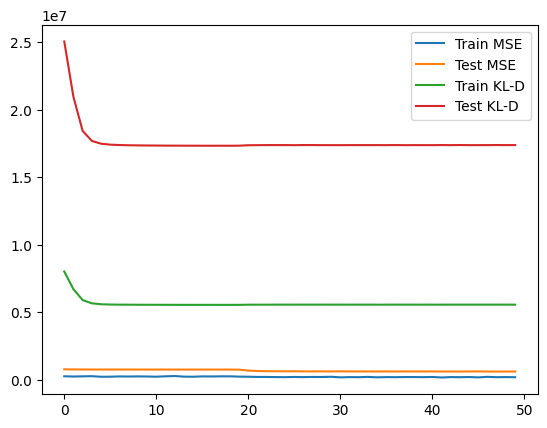

In [38]:
plt.plot(train_losses_mse, label='Train MSE')
plt.plot(test_losses_mse, label='Test MSE')

plt.plot(train_losses_kld, label='Train KL-D')
plt.plot(test_losses_kld, label='Test KL-D')
plt.legend()
plt.show()

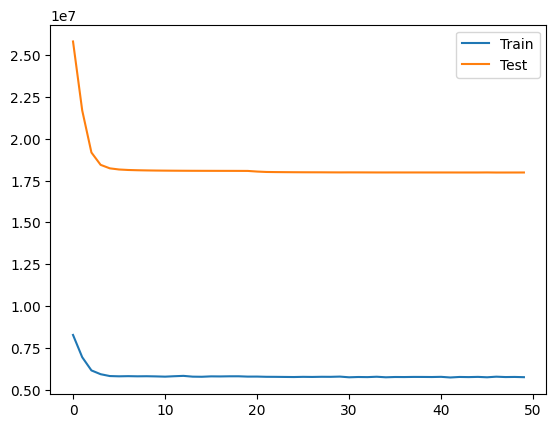

In [39]:
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.show()

In [40]:
# torch.save(model.state_dict(), 'results/CIFAR10.pth')

# Prediction: Image with wrong number

In [41]:
count = 0
all_predictions_wrong = []
all_predictions_correct = []
all_labels = []

for data, num_encoding, label in test_loader:

    r_idx = random.randrange(0, batch_size)

    input1_orig = data[r_idx]
    input2_orig  = num_encoding[r_idx]
    gt_orig = label[r_idx]

    correct_label = categorical_to_num(np.array(input2_orig))

    while count < 25:
        r_label = random.randrange(0, 10)
        if r_label != correct_label:
            wrong_label = r_label

            all_labels.append([correct_label, wrong_label])

            wrong_label_vector = num_to_categorical(wrong_label, 10)

            input1 = input1_orig.clone()
            input2 = input2_orig.clone()
            gt = gt_orig.clone()

            input2_mod = input2_orig.clone()
            input2_mod = torch.tensor(wrong_label_vector)

            ## unqueeze to get batch dim
            input1 = input1.unsqueeze(0)
            input2 = input2.unsqueeze(0)

            input2_mod = input2_mod.unsqueeze(0)
            gt = gt.unsqueeze(0)

            # print(f'gt label {correct_label}, wrong label added {wrong_label}')

            prediction_correct = model(input1.to(device), input2.to(device)).detach().cpu().squeeze(0).squeeze(0)
            prediction_wrong = model(input1.to(device), input2_mod.to(device)).detach().cpu().squeeze(0).squeeze(0)

            all_predictions_correct.append(prediction_correct)
            all_predictions_wrong.append(prediction_wrong)

            count += 1

    break

In [42]:
id2classes = {classes_dict[key]:key for key in classes_dict.keys()}

In [43]:
def plot_grid(image, labels, noise=False):

    nrows = 5
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")

            img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar
        
            ax[i, j].imshow(img)

            correct, wrong = labels[index]
            if noise:
                s = f'True: {id2classes[correct]}\nNoise: {id2classes[wrong]}'
                ax[i, j].text(0, 5, s, color='Orange')
            else:
                s = f'True: {id2classes[correct]}'
                ax[i, j].text(0, 2, s, color='Orange')

    plt.subplots_adjust(wspace=0, hspace=0.01)


/tmp/ipykernel_1316279/1923410761.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar


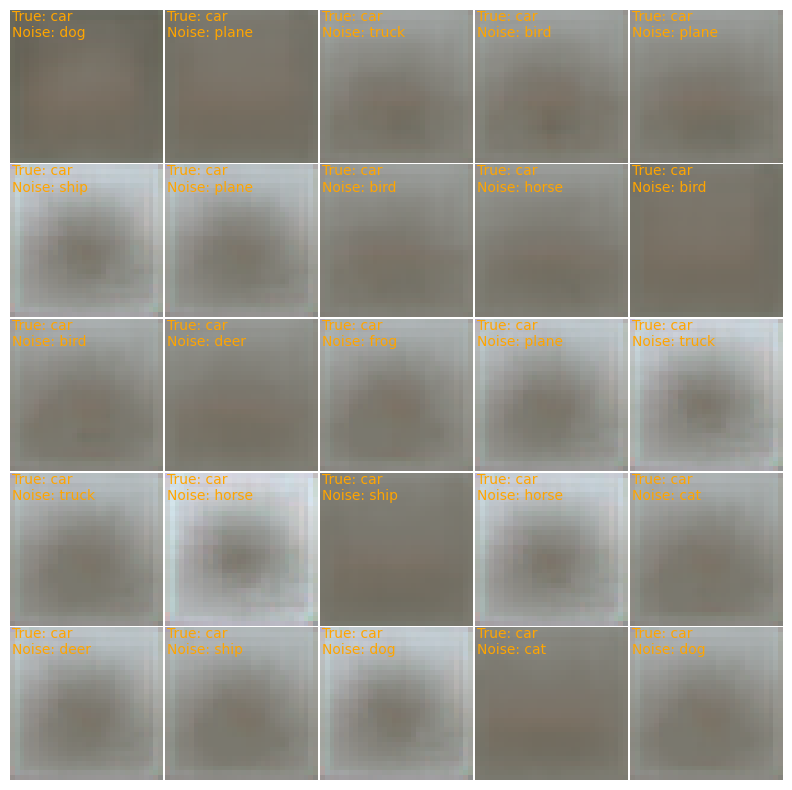

In [44]:
plot_grid(all_predictions_wrong, all_labels, True)

/tmp/ipykernel_1316279/1923410761.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image[index]).permute(1, 2, 0).numpy()*sigma_cifar + mu_cifar


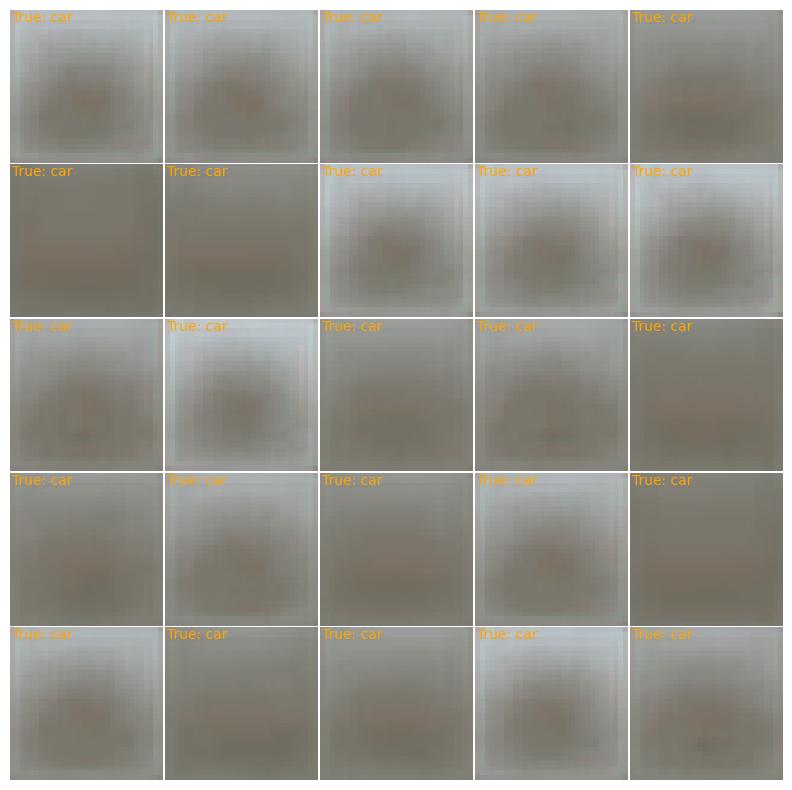

In [45]:
plot_grid(all_predictions_correct, all_labels, False)